In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib inline

In [2]:
#Import Tree Models from scratch functions
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/TreeModelsFromScratch")

from DecisionTree import DecisionTree
from RandomForest import RandomForest
#from SmoothShap import verify_shap_model, smooth_shap

In [3]:
# Import other libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#import seaborn as sns
from imodels import HSTreeClassifier, HSTreeRegressor, HSTreeClassifierCV, HSTreeRegressorCV
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from copy import deepcopy
#from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, KFold
#import shap
#from shap.explainers._tree import SingleTree

In [4]:
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
# change working directory to imodels-experiment folder
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../../imodels-experiments')
    
module_path_imodels = os.getcwd()
if module_path not in sys.path:
    sys.path.append(module_path_imodels+"/config/shrinkage")
    
from imodels.util.data_util import get_clean_dataset
from datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from util import DATASET_PATH

#pd.options.display.max_rows = 100

# Recreation of results from hierarchical shrinkage paper

Hierarchical Shrinkage: Improving the accuracy and interpretability of tree-based models <br>
[Link to paper](https://proceedings.mlr.press/v162/agarwal22b.html)


>HS is integrated into the imodels package [imodels](github.com/csinva/imodels) (Singh et al., 2021) with an sklearn compatible API. Experiments for reproducing the results here can be found at [imodels-experiments](github.com/Yu-Group/imodels-experiments)

Unfortunately, not all experiments/ figures of the paper can be found in the aforementioned GitHub repository, therefore some of the charts will not be identical to the paper.

## HS performance across various datasets (Fig. 4 )

> *Hierarchical Shrinkage (solid lines) often improves predictive performance across various datasets, particularly for small datasets. (A) Top two rows show results for classification datasets (measured by AUC of the ROC curve) and (B) the next two rows show results for regression datasets (measured by R2). HS often significantly improves the performance over CART, CART with CCP, and (C) leaf-based shrinkage. (D) HS even improves results for Random Forests as a function of the number of trees. Across all panels, errors bars show standard error of the mean computed over 10 random data splits. Note that the y-axis scales differ across plots.*

The authors did not provide more information on how the comparison plots were created.  
By observing the plots from the original paper one realizes that the performance of the CART models is never above the hsCart model. This might indicate, that at each iteration (n_leaves) a GridSearch for lambda was conducted. For first comparisons we decided to mantain a constant value for lambda for each plot.  

In the current state of the `TreeModelsfromScratch` there is no parameter to specify the number of leaves per tree. 
Therefore, we will create a 2nd plot where we use tree depth as scale for the x-axis. If we assume, that the information gain p. split will not yield 0 before a tree depth of 7, this 2nd plot should yield similar results to the original plot (maximum number of leaves in binary search tree = 2^d, where d is the depth (starting from 0))

Also, there is no cost-complexity pruning (CCP) implemented in `TreeModelsfromScratch`. As our focus for now is more the comparison between HS from imodels and the scratch package, we will discard plots with CCP for now.

### Create functions to recreate plot

In [77]:
def cross_val_score_scratch(estimator, X, y, cv=10, scoring_func=roc_auc_score, shuffle=True, random_state=None):
    
    kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)
    scores = []
    
    for train_index, test_index in kf.split(X):

        # Create true copy of estimator (refitting of scratch models is not possbile)
        estimator_copy = deepcopy(estimator)
        
        #split data
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        #fit estimator, predict & score
        estimator_copy.fit(X_train, y_train)
        y_pred = estimator_copy.predict(X_test)
        scores.append(scoring_func(y_test, y_pred))

    return scores

In [88]:
def create_performance_plot(X, y, model_type="classification", cv=10, scoring_func=roc_auc_score, reg_param=100, 
                                  shuffle=True, random_state=42, dset_name=None, show_adapted_plot=False):

    
    # Original plot with n_leaves as x-axis
    n_leafs = [2,4,6,12,15,18,23,26,27,28,29,30]

    cv_res_sk = []
    cv_res_im = []
    
    estimator_sk = DecisionTreeClassifier if model_type=="classification" else DecisionTreeRegressor
    estimator_im = HSTreeClassifier if model_type=="classification" else HSTreeRegressor    

    for n_leaf_nodes in n_leafs:

        #sklearn
        clf_tree_sk = estimator_sk(max_leaf_nodes=n_leaf_nodes, random_state=random_state)
        cv_res_sk.append(cross_val_score_scratch(clf_tree_sk, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))

        #imodels 
        clf_tree_im = estimator_im(deepcopy(clf_tree_sk), reg_param=reg_param)
        cv_res_im.append(cross_val_score_scratch(clf_tree_im, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))
        
    #Compute standard error of mean
    data_sk = np.array(cv_res_sk)
    sem_data_sk = np.std(data_sk, ddof=1, axis=1) / np.sqrt(np.size(data_sk, axis=1))

    data_im = np.array(cv_res_im)
    sem_data_im = np.std(data_im, ddof=1, axis=1) / np.sqrt(np.size(data_im, axis=1))
    
    #Create plot
    fig, axs = plt.subplots(1,2, figsize=(15,5))
    
    fig.suptitle(f"{dset_name} (n = {X.shape[0]}, p = {X.shape[1]})")
    
    axs[0].errorbar(x=n_leafs, y=np.array(data_im).mean(axis=1), yerr=sem_data_im, color="tab:blue", 
                   alpha=1., linewidth=3, marker="o")
    axs[0].errorbar(x=n_leafs, y=np.array(data_sk).mean(axis=1), yerr=sem_data_sk, color="tab:blue", 
                   alpha=.5, linewidth=3, marker="o")

    axs[0].set_xlabel("number of leaves")
    y_label = "AUC" if str(scoring_func).split()[1]=="roc_auc_score" else "R2"
    axs[0].set_ylabel(y_label)
    axs[0].legend(["hsCART", "CART"])
    axs[0].set_title("Original plot: n_leaves as x-axis")
    
    # if only original plot should be shown
    if not show_adapted_plot:
        axs[-1].axis('off')
        plt.show()
        return [[data_sk, sem_data_sk], [data_im, sem_data_im]]
    
    #Adapted plot with tree_depth as x-axis
    tree_depths = range(1,7)

    new_cv_res_sk = []
    new_cv_res_im = []
    new_cv_res_scr = []
    new_cv_res_scrHS = []
    
    for depth in tree_depths:

        #sklearn
        clf_tree_sk = estimator_sk(max_depth=depth, random_state=random_state)
        new_cv_res_sk.append(cross_val_score_scratch(clf_tree_sk, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))

        #imodels 
        clf_tree_im = estimator_im(deepcopy(clf_tree_sk), reg_param=reg_param)
        new_cv_res_im.append(cross_val_score_scratch(clf_tree_im, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))
        
        #scratch
        clf_tree_scr = DecisionTree(max_depth=depth, treetype=model_type, random_state=random_state)
        new_cv_res_scr.append(cross_val_score_scratch(clf_tree_scr, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))

        #scratchHS
        clf_tree_scrHS = DecisionTree(max_depth=depth, treetype=model_type, HShrinkage=True, HS_lambda=reg_param, random_state=random_state)
        new_cv_res_scrHS.append(cross_val_score_scratch(clf_tree_scrHS, X, y, cv=cv, scoring_func=scoring_func, 
                                                 shuffle=shuffle, random_state=random_state))        
        
    #Compute standard error of mean
    new_data_sk = np.array(new_cv_res_sk)
    new_sem_data_sk = np.std(new_data_sk, ddof=1, axis=1) / np.sqrt(np.size(new_data_sk, axis=1))

    new_data_im = np.array(new_cv_res_im)
    new_sem_data_im = np.std(new_data_im, ddof=1, axis=1) / np.sqrt(np.size(new_data_im, axis=1))
    
    new_data_scr = np.array(new_cv_res_scr)
    new_sem_data_scr = np.std(new_data_scr, ddof=1, axis=1) / np.sqrt(np.size(new_data_scr, axis=1))

    new_data_scrHS = np.array(new_cv_res_scrHS)
    new_sem_data_scrHS = np.std(new_data_scrHS, ddof=1, axis=1) / np.sqrt(np.size(new_data_scrHS, axis=1))
    
    #Create adapted plot
    axs[1].errorbar(x=tree_depths, y=np.array(new_data_im).mean(axis=1), yerr=new_sem_data_im, color="tab:blue", 
                   alpha=1., linewidth=3, marker="o")
    axs[1].errorbar(x=tree_depths, y=np.array(new_data_scrHS).mean(axis=1), yerr=new_sem_data_scrHS, color="orange", 
                   alpha=1., linewidth=3, marker="o")
    axs[1].errorbar(x=tree_depths, y=np.array(new_data_sk).mean(axis=1), yerr=new_sem_data_sk, color="tab:blue", 
                   alpha=.5, linewidth=3, marker="o")
    axs[1].errorbar(x=tree_depths, y=np.array(new_data_scr).mean(axis=1), yerr=new_sem_data_scr, color="orange", 
                   alpha=.5, linewidth=3, marker="o")


    axs[1].set_xlabel("Max tree depth")
    y_label = "AUC" if str(scoring_func).split()[1]=="roc_auc_score" else "R2"
    axs[1].set_ylabel(y_label)
    axs[1].legend(["hsCART", "hsCART scratch", "CART", "CART scratch"])
    axs[1].set_title("Adapted plot: maximum tree depth as x-axis")
    
    plt.show()
    return [[data_sk, sem_data_sk], [data_im, sem_data_im]], [[new_data_sk, new_sem_data_sk], [new_data_im, new_sem_data_im], [new_data_scr, new_sem_data_scr], [new_data_scrHS, new_sem_data_scrHS]]
    

### Classification datasets (Fig. 4 (A))

#### Hearts dataset

In [83]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[1]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

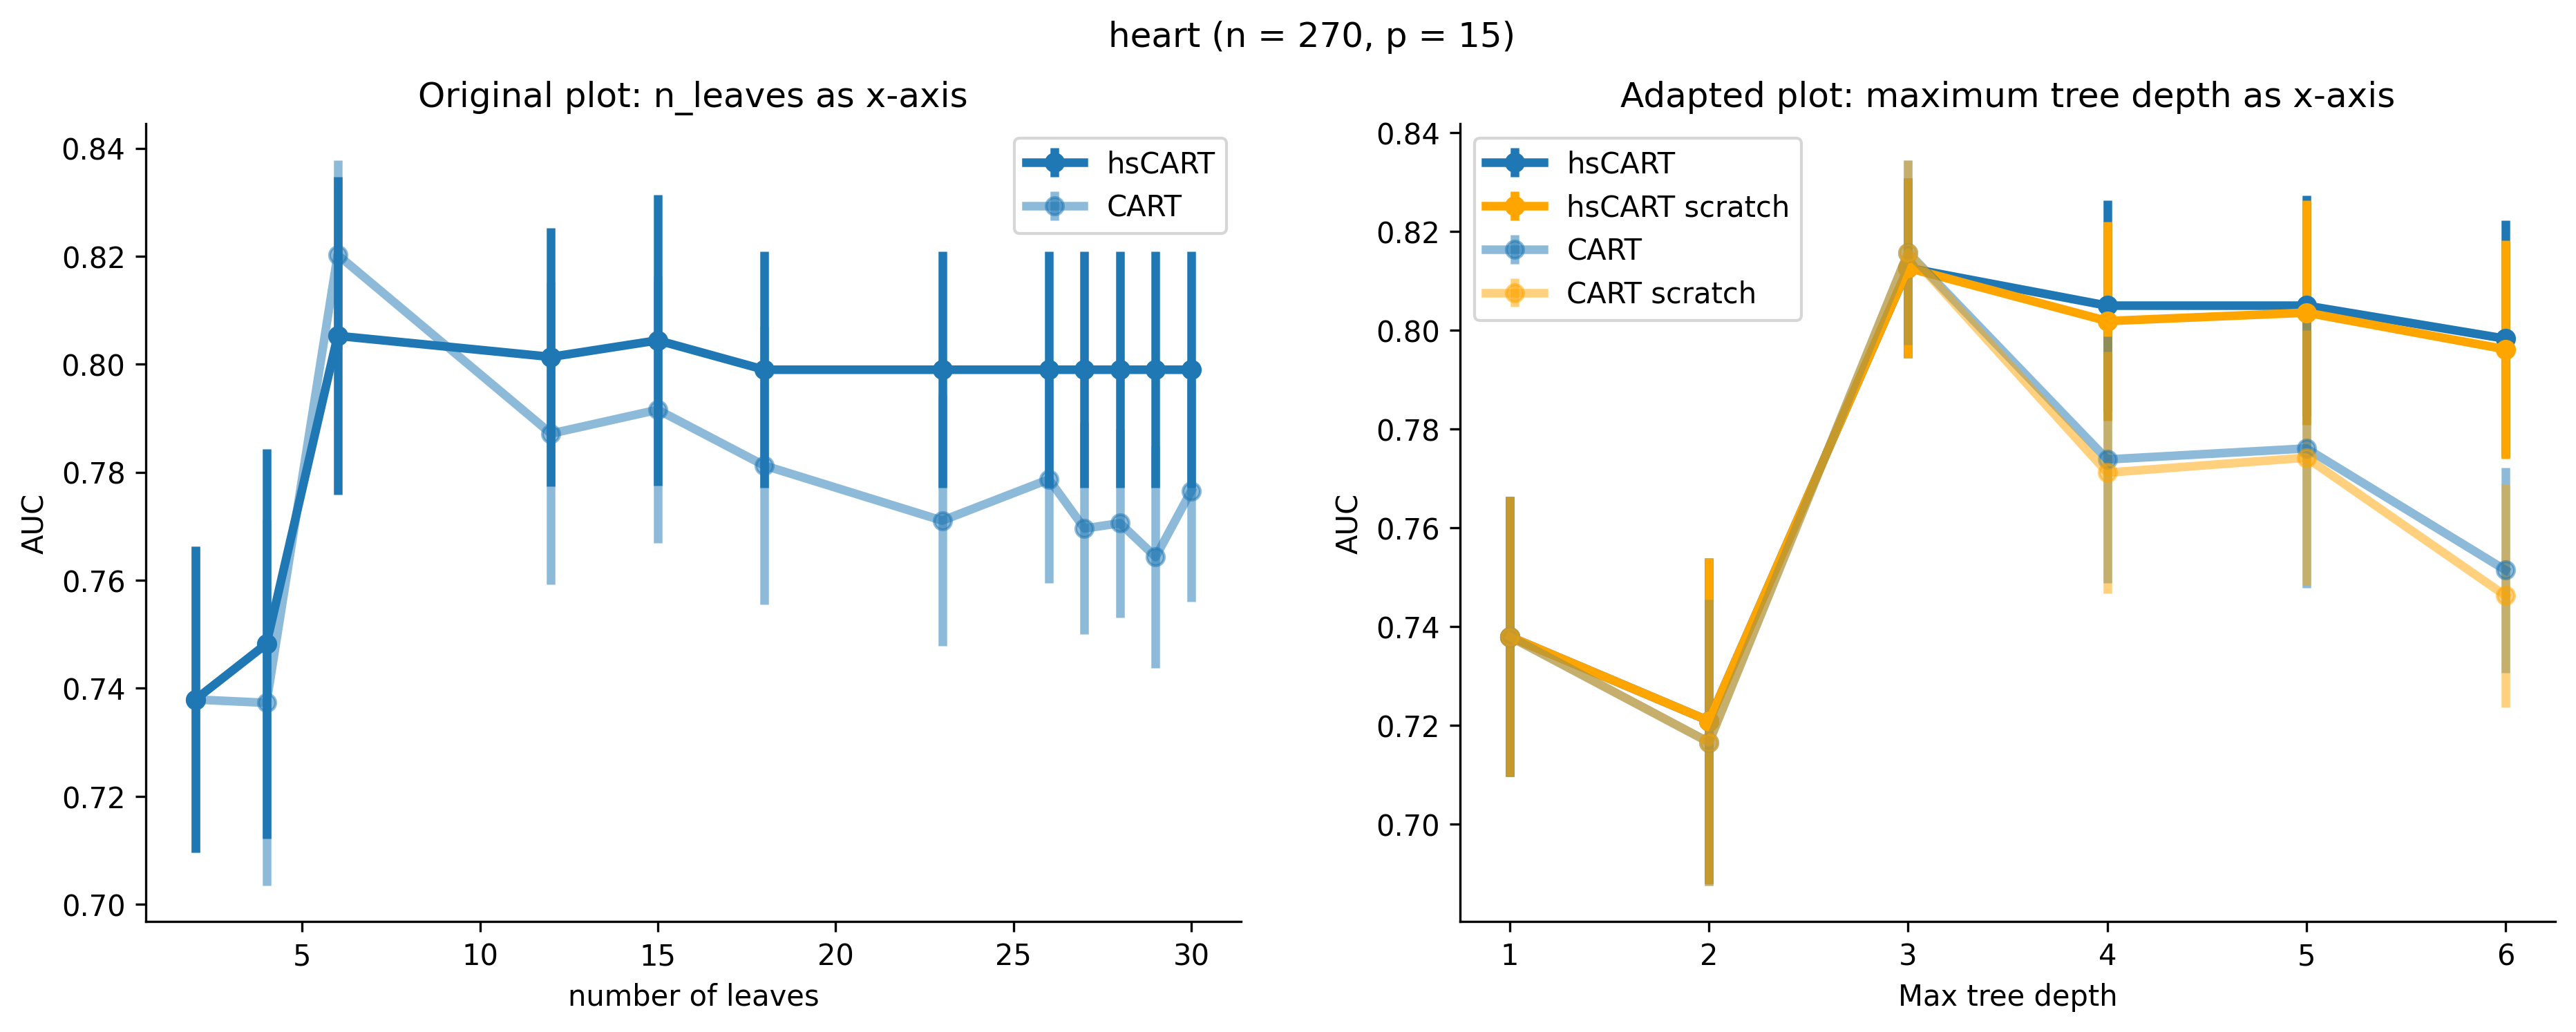

In [89]:
cv_res_orig, cv_res_new = create_performance_plot(X, y, scoring_func=roc_auc_score, model_type="classification",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- Both, the scratch model with and without HS yield very similar results as its respective functions from sklearn, imodels
- The drop in AUC for the CART models without HS is very similar to the plot shown in the original paper

#### Breast-cancer dataset

In [90]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[2]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

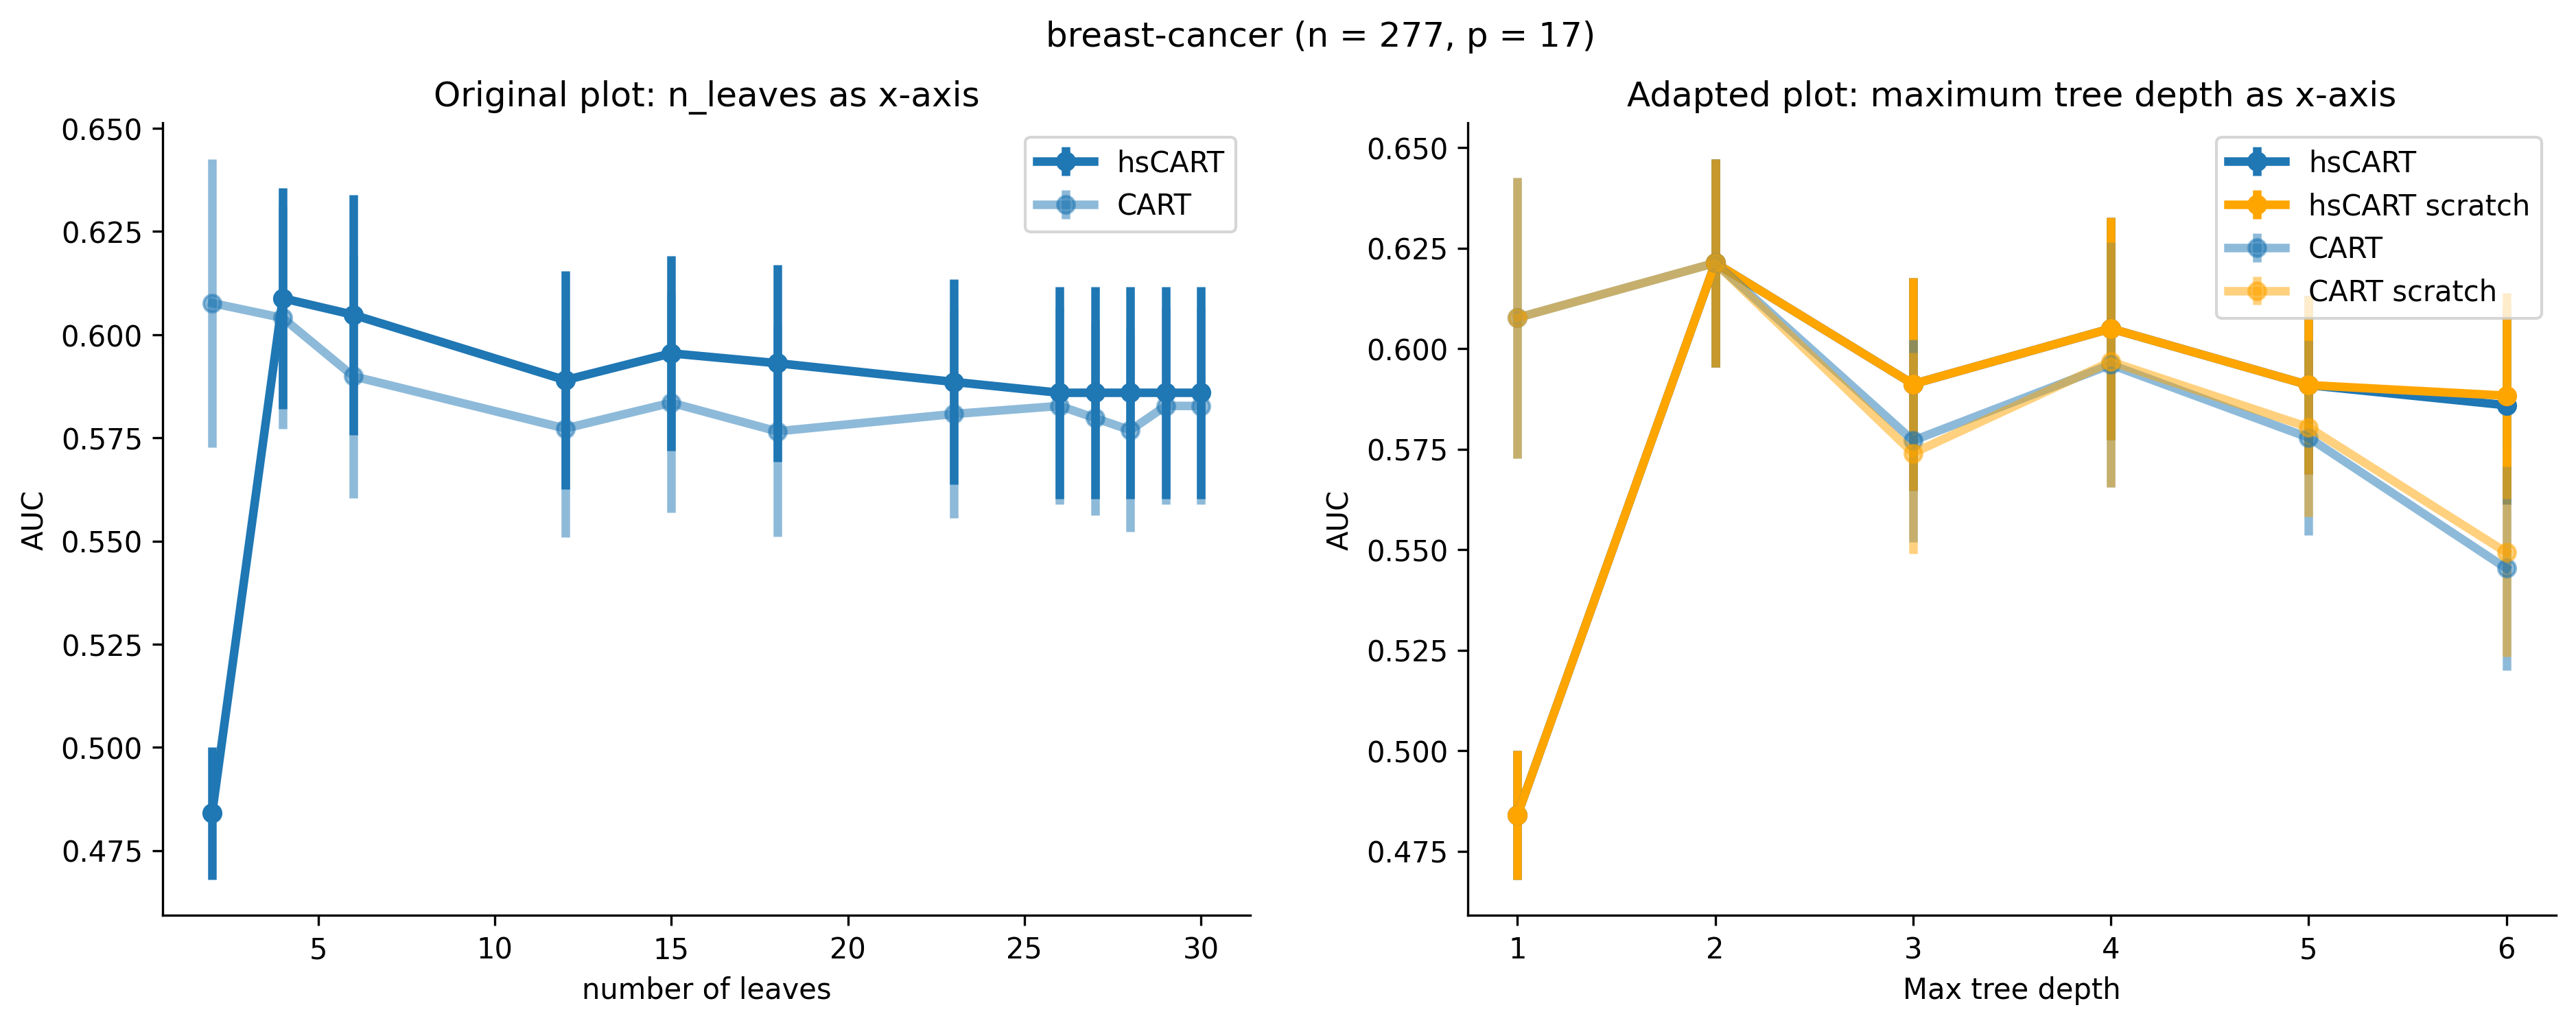

In [91]:
cv_res_orig_bc, cv_res_new_bc = create_performance_plot(X, y, scoring_func=roc_auc_score, model_type="classification",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- Unlike in the paper, the AUC for the CART models without HS does not drop, but stays rather stable. This may be due to a different random seed? 

#### Haberman dataset

In [92]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[3]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

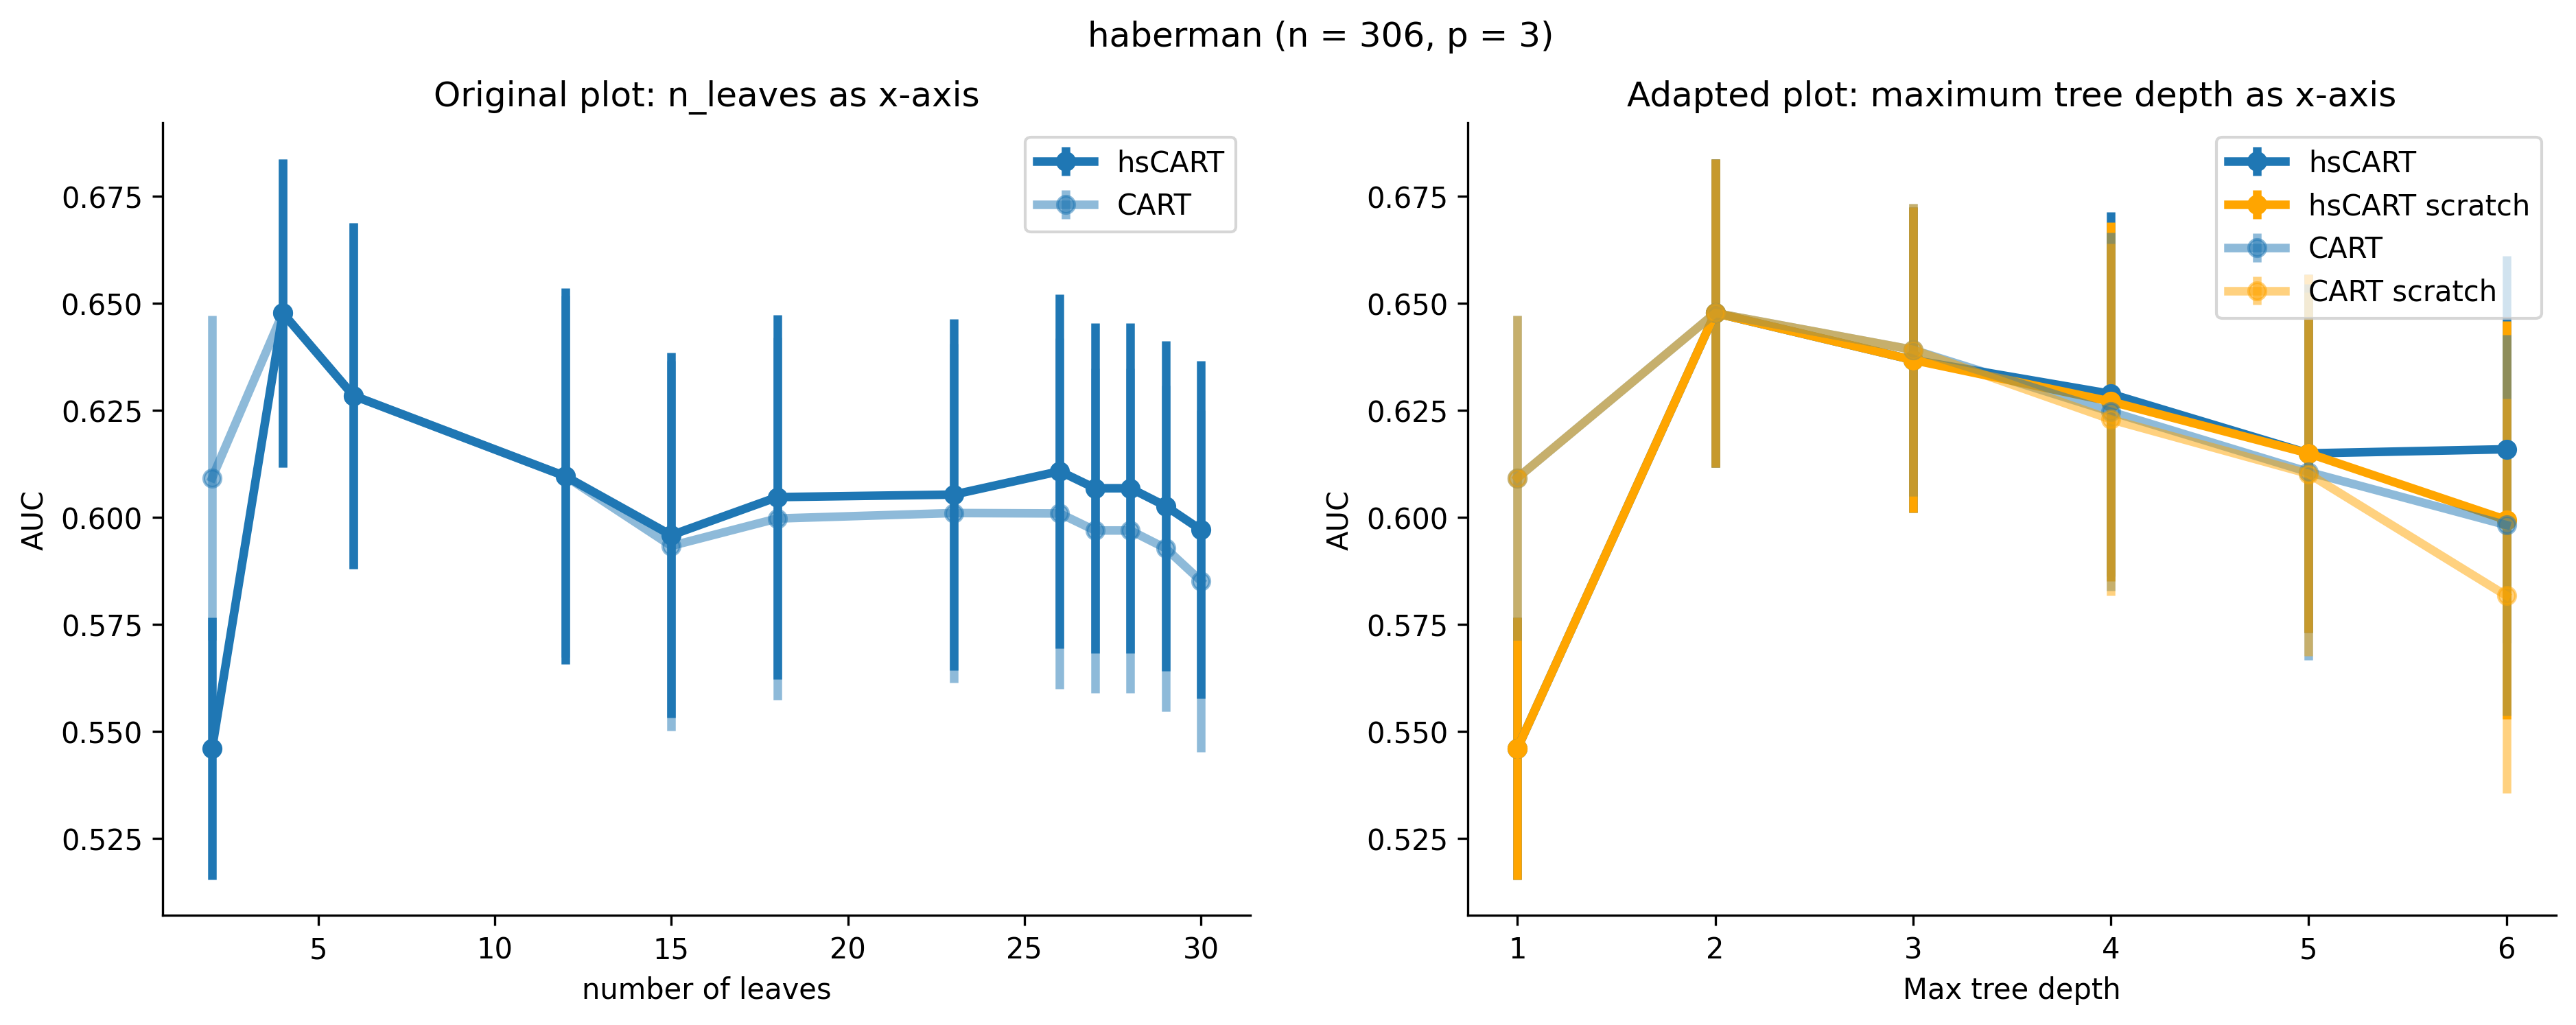

In [98]:
cv_res_orig_hm, cv_res_new_hm = create_performance_plot(X, y, scoring_func=roc_auc_score, model_type="classification",
                                                      reg_param=0.1, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- Unlike in the paper, the AUC for the CART models without HS does not drop, but stays rather stable. This may be due to a different random seed?

### Ionosphere dataset

In [99]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[4]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

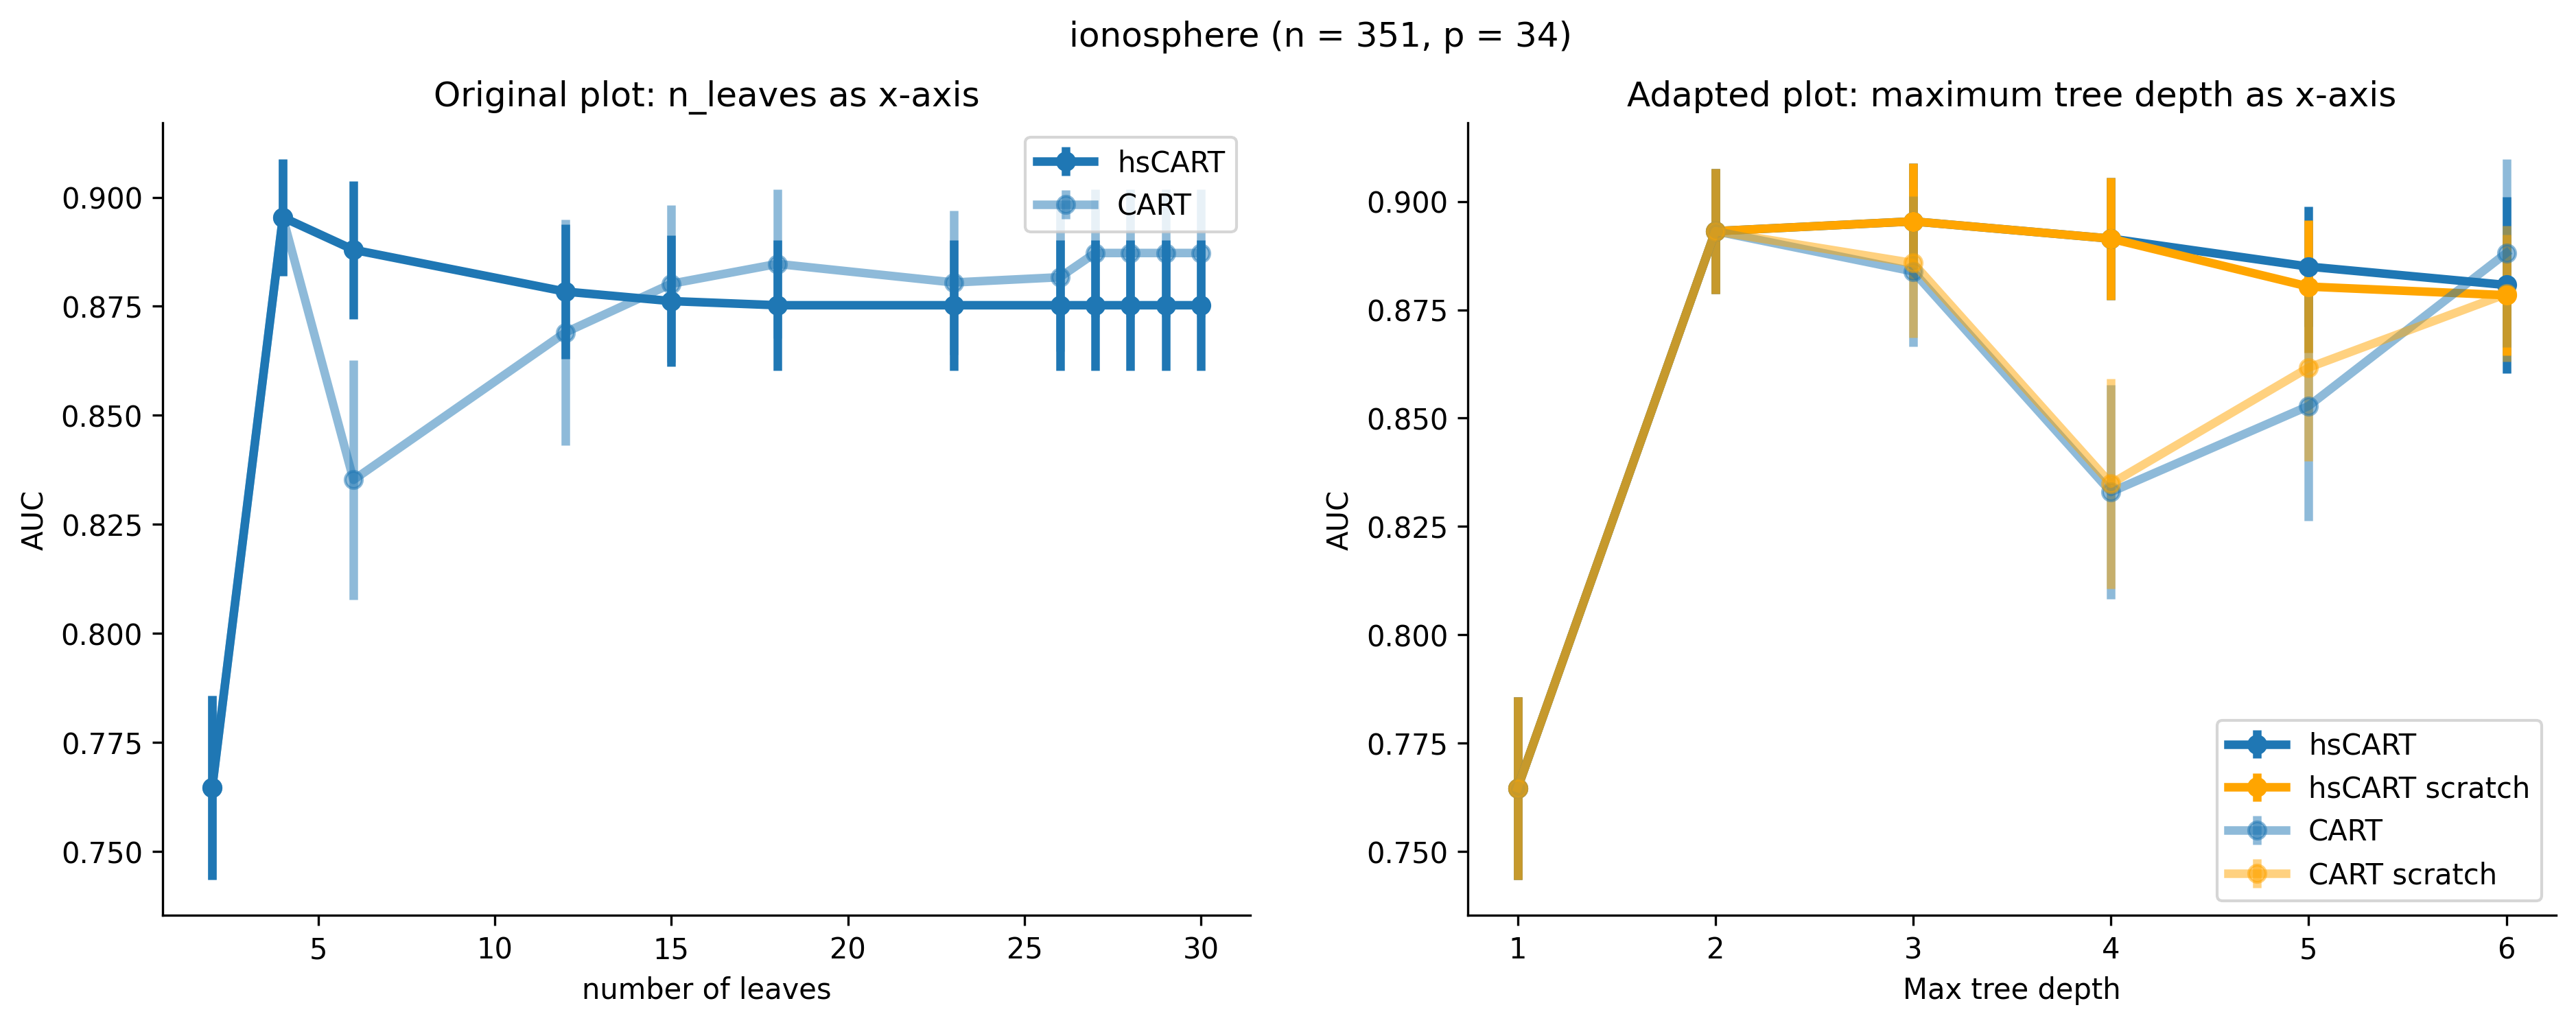

In [100]:
cv_res_orig_io, cv_res_new_io = create_performance_plot(X, y, scoring_func=roc_auc_score, model_type="classification",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- The adapted plot appears to be similar to the original paper, as it shows the intermediate performance drop of CART models
- Interestingly, in the original paper the x-axis only for this plot was cut after 15. Perhaps they did not want to show the later intersection of CART models?

### Diabetes dataset

In [106]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[5]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

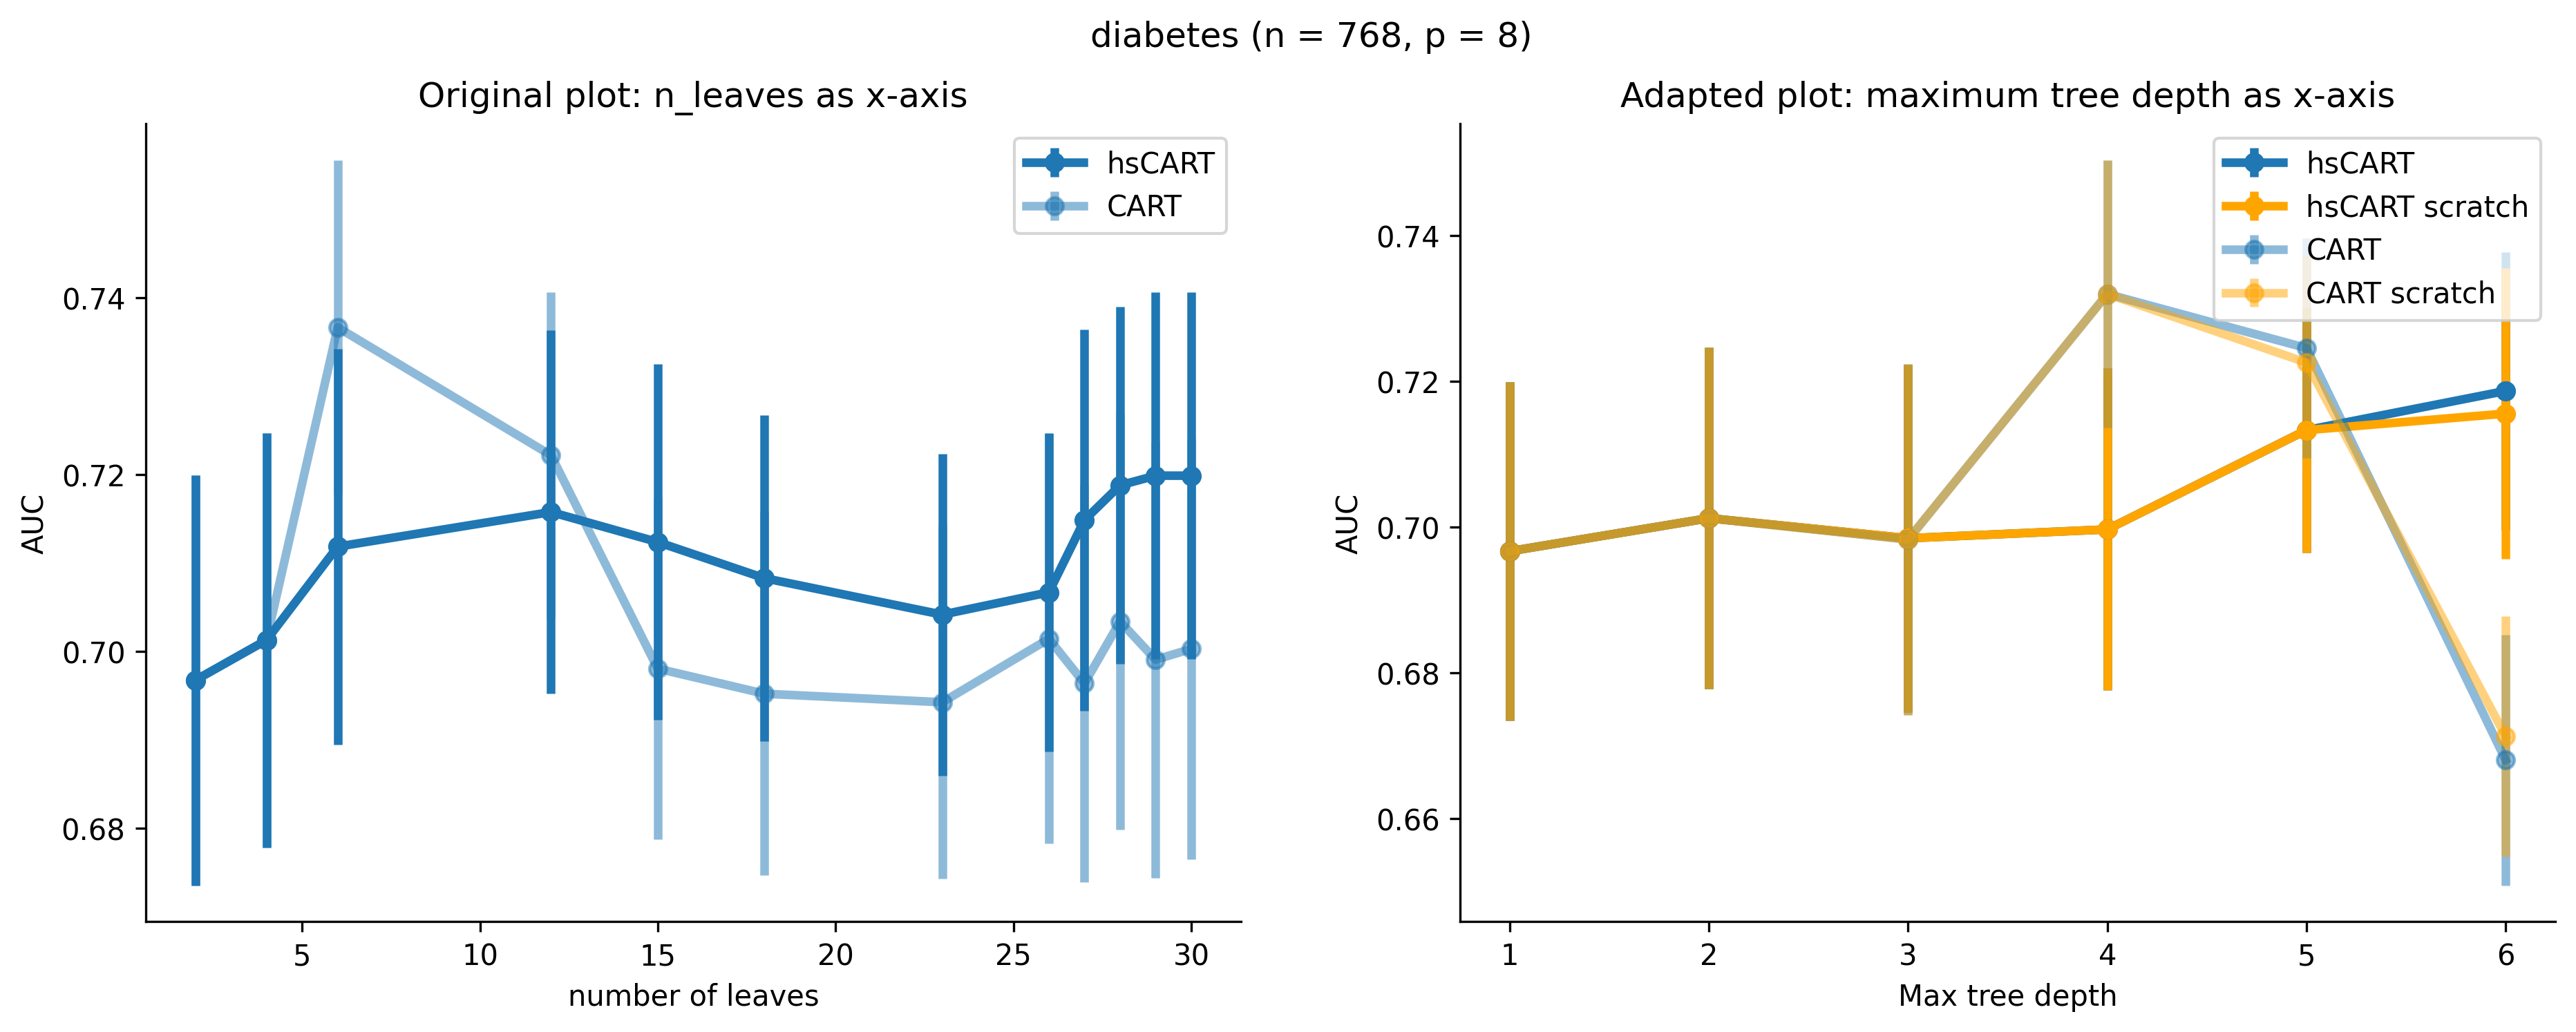

In [107]:
cv_res_orig_dia, cv_res_new_dia = create_performance_plot(X, y, scoring_func=roc_auc_score, model_type="classification",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- The AUC for the hsCART models stays rather stable, but below the AUC scores from the original paper. This may be due to a different random seed and/or no hyperparameter-tuning of lambda
- The spike from CART models also does not appear in the original paper. Again this might be due to chance.

#### German-credit dataset

In [108]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_CLASSIFICATION[6]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

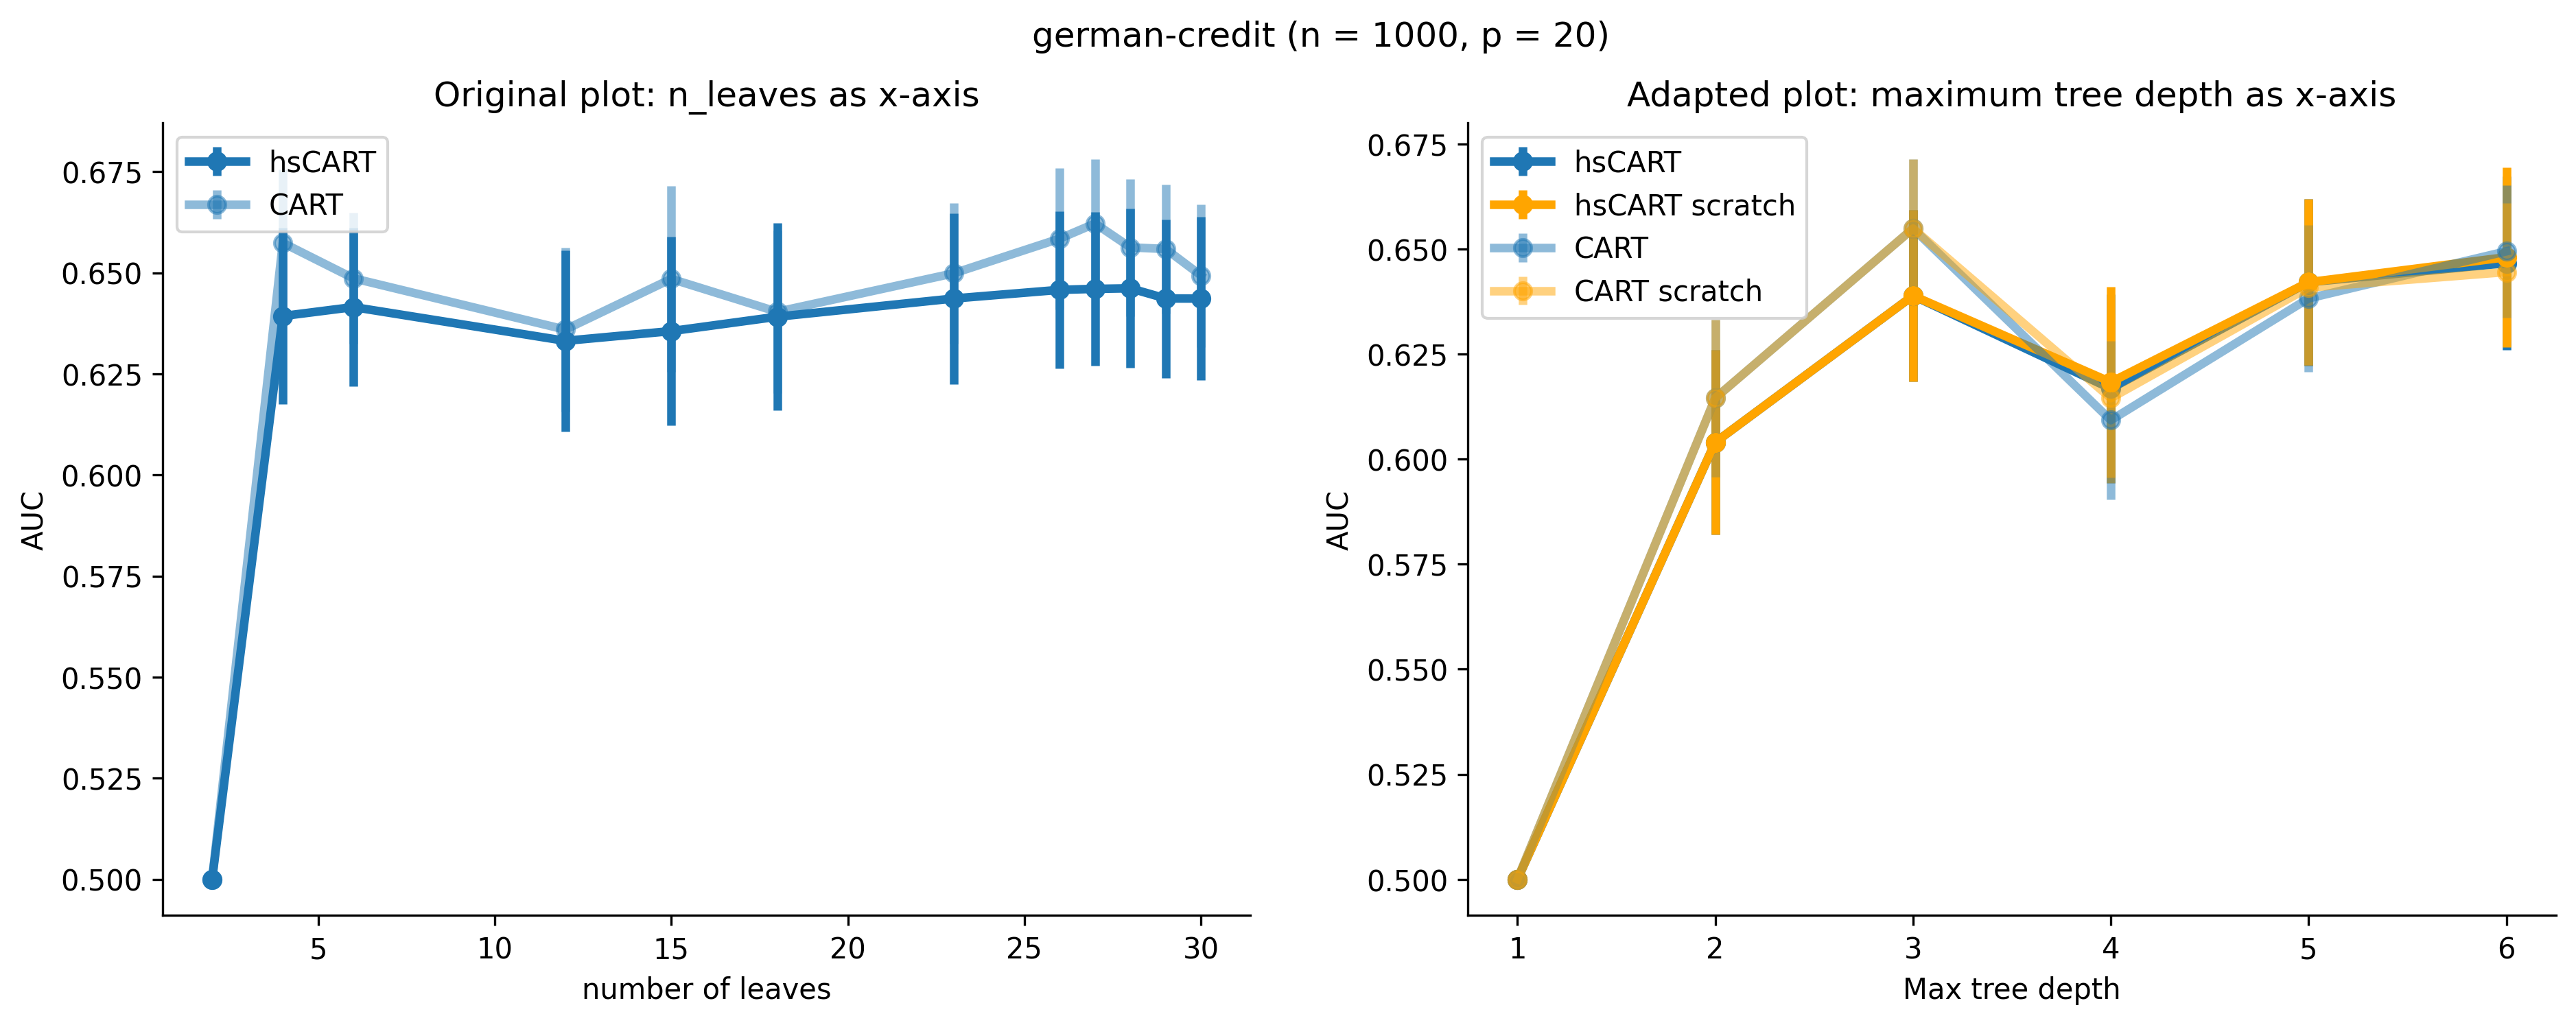

In [109]:
cv_res_orig_gercre, cv_res_new_gercre = create_performance_plot(X, y, scoring_func=roc_auc_score, model_type="classification",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- The AUC scores for all models stay rather stable, but below the AUC scores from the original paper. This may be due to a different random seed and/or no hyperparameter-tuning of lambda

### Regression datasets (Fig. 4 (B))

#### Friedman1 dataset

In [117]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_REGRESSION[0]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

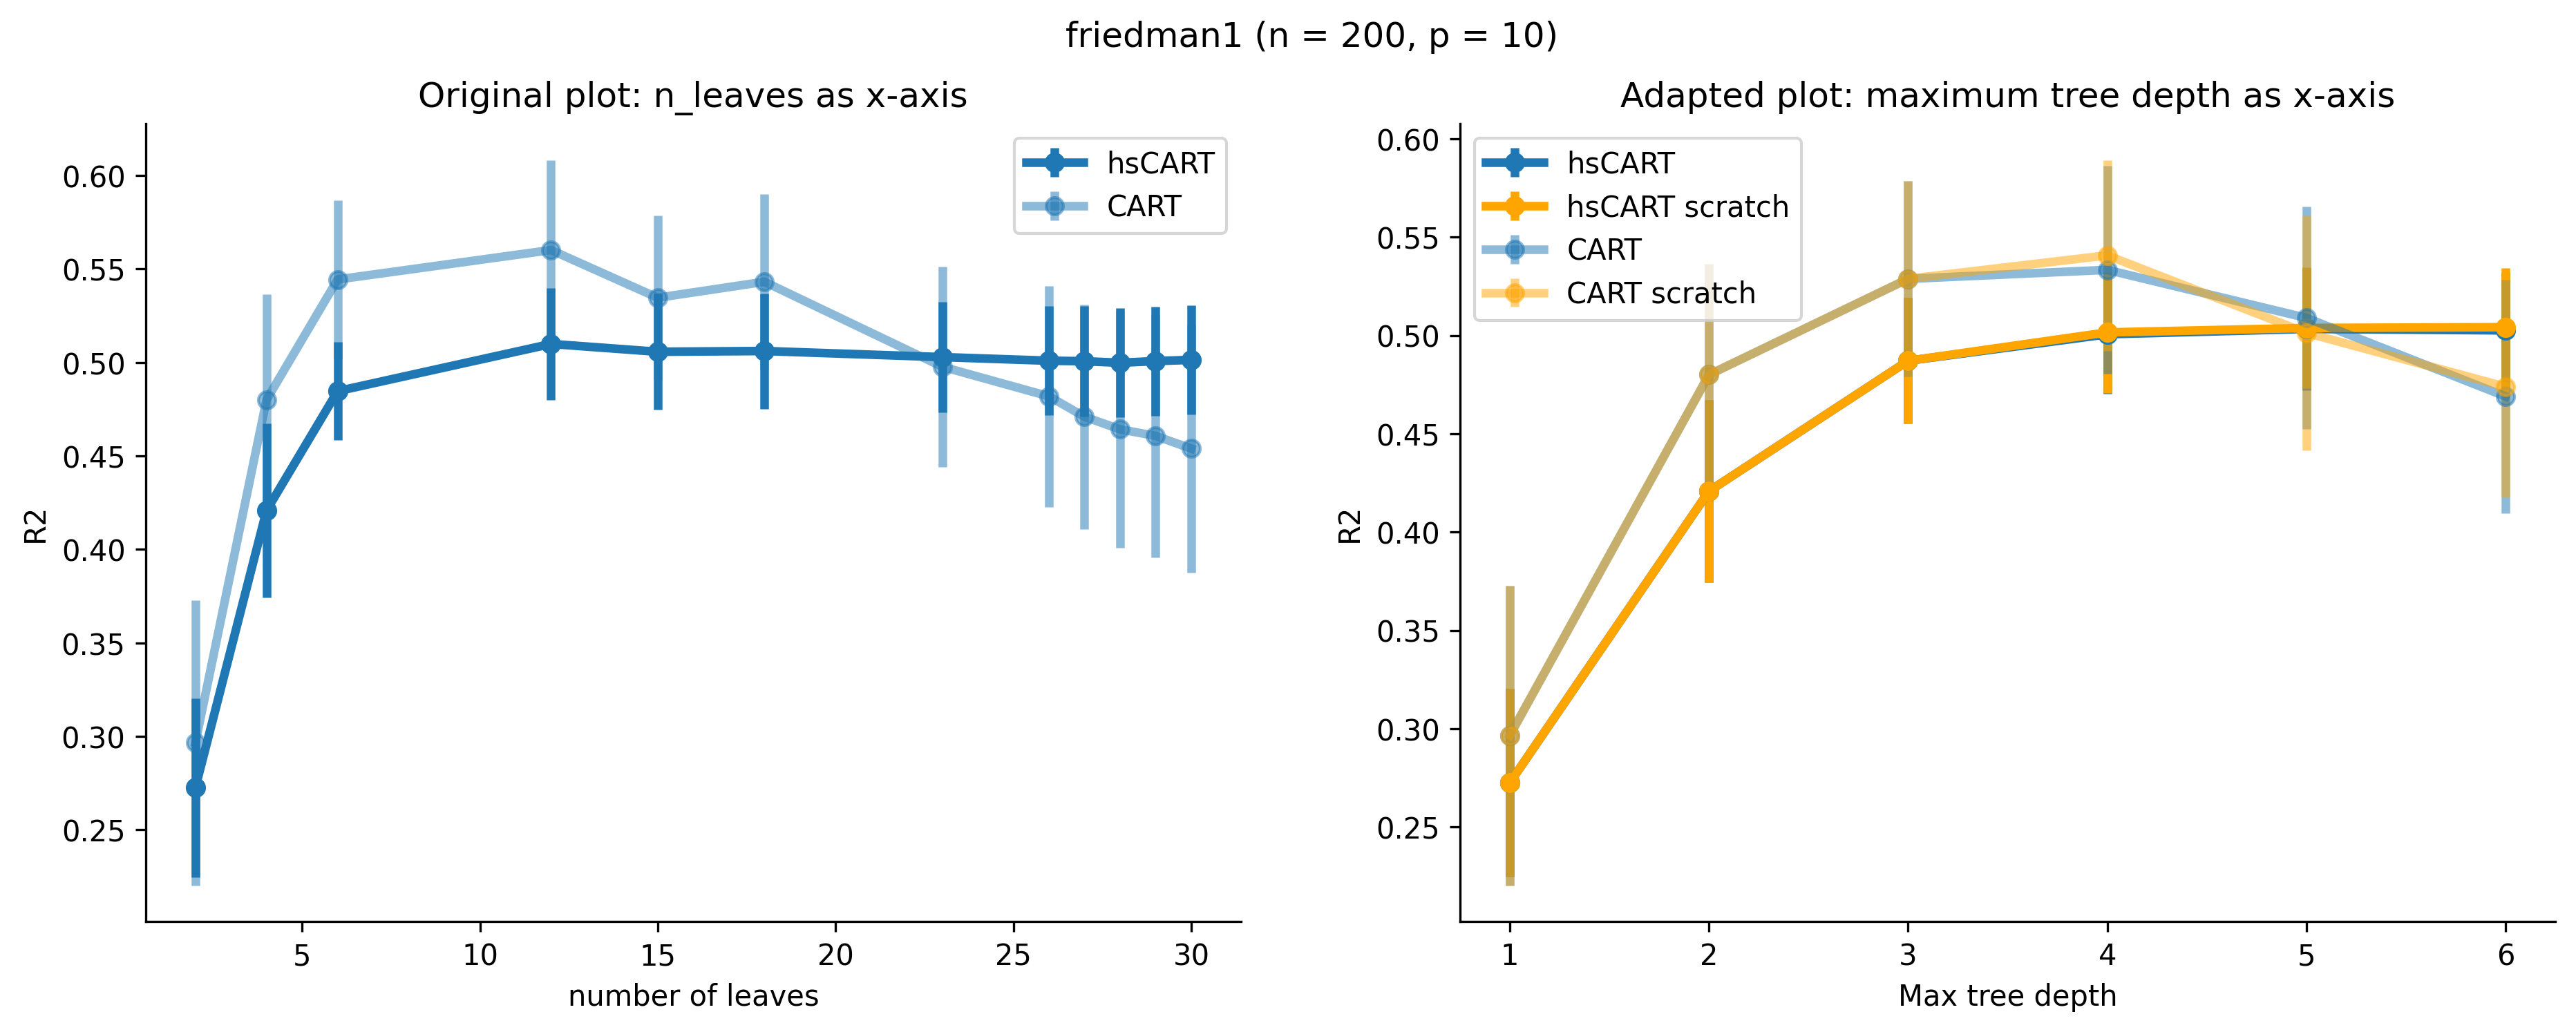

In [118]:
cv_res_frie1, cv_resfrie1 = create_performance_plot(X, y, scoring_func=r2_score, model_type="regression",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- The R2 scores of both plots appear to be similar to the original paper, but the R2 score of the CART models is never above the hsCart model. This might be due to different seeds, or missing hyperparameter-tuning.

#### Friedman3 dataset

In [119]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_REGRESSION[2]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

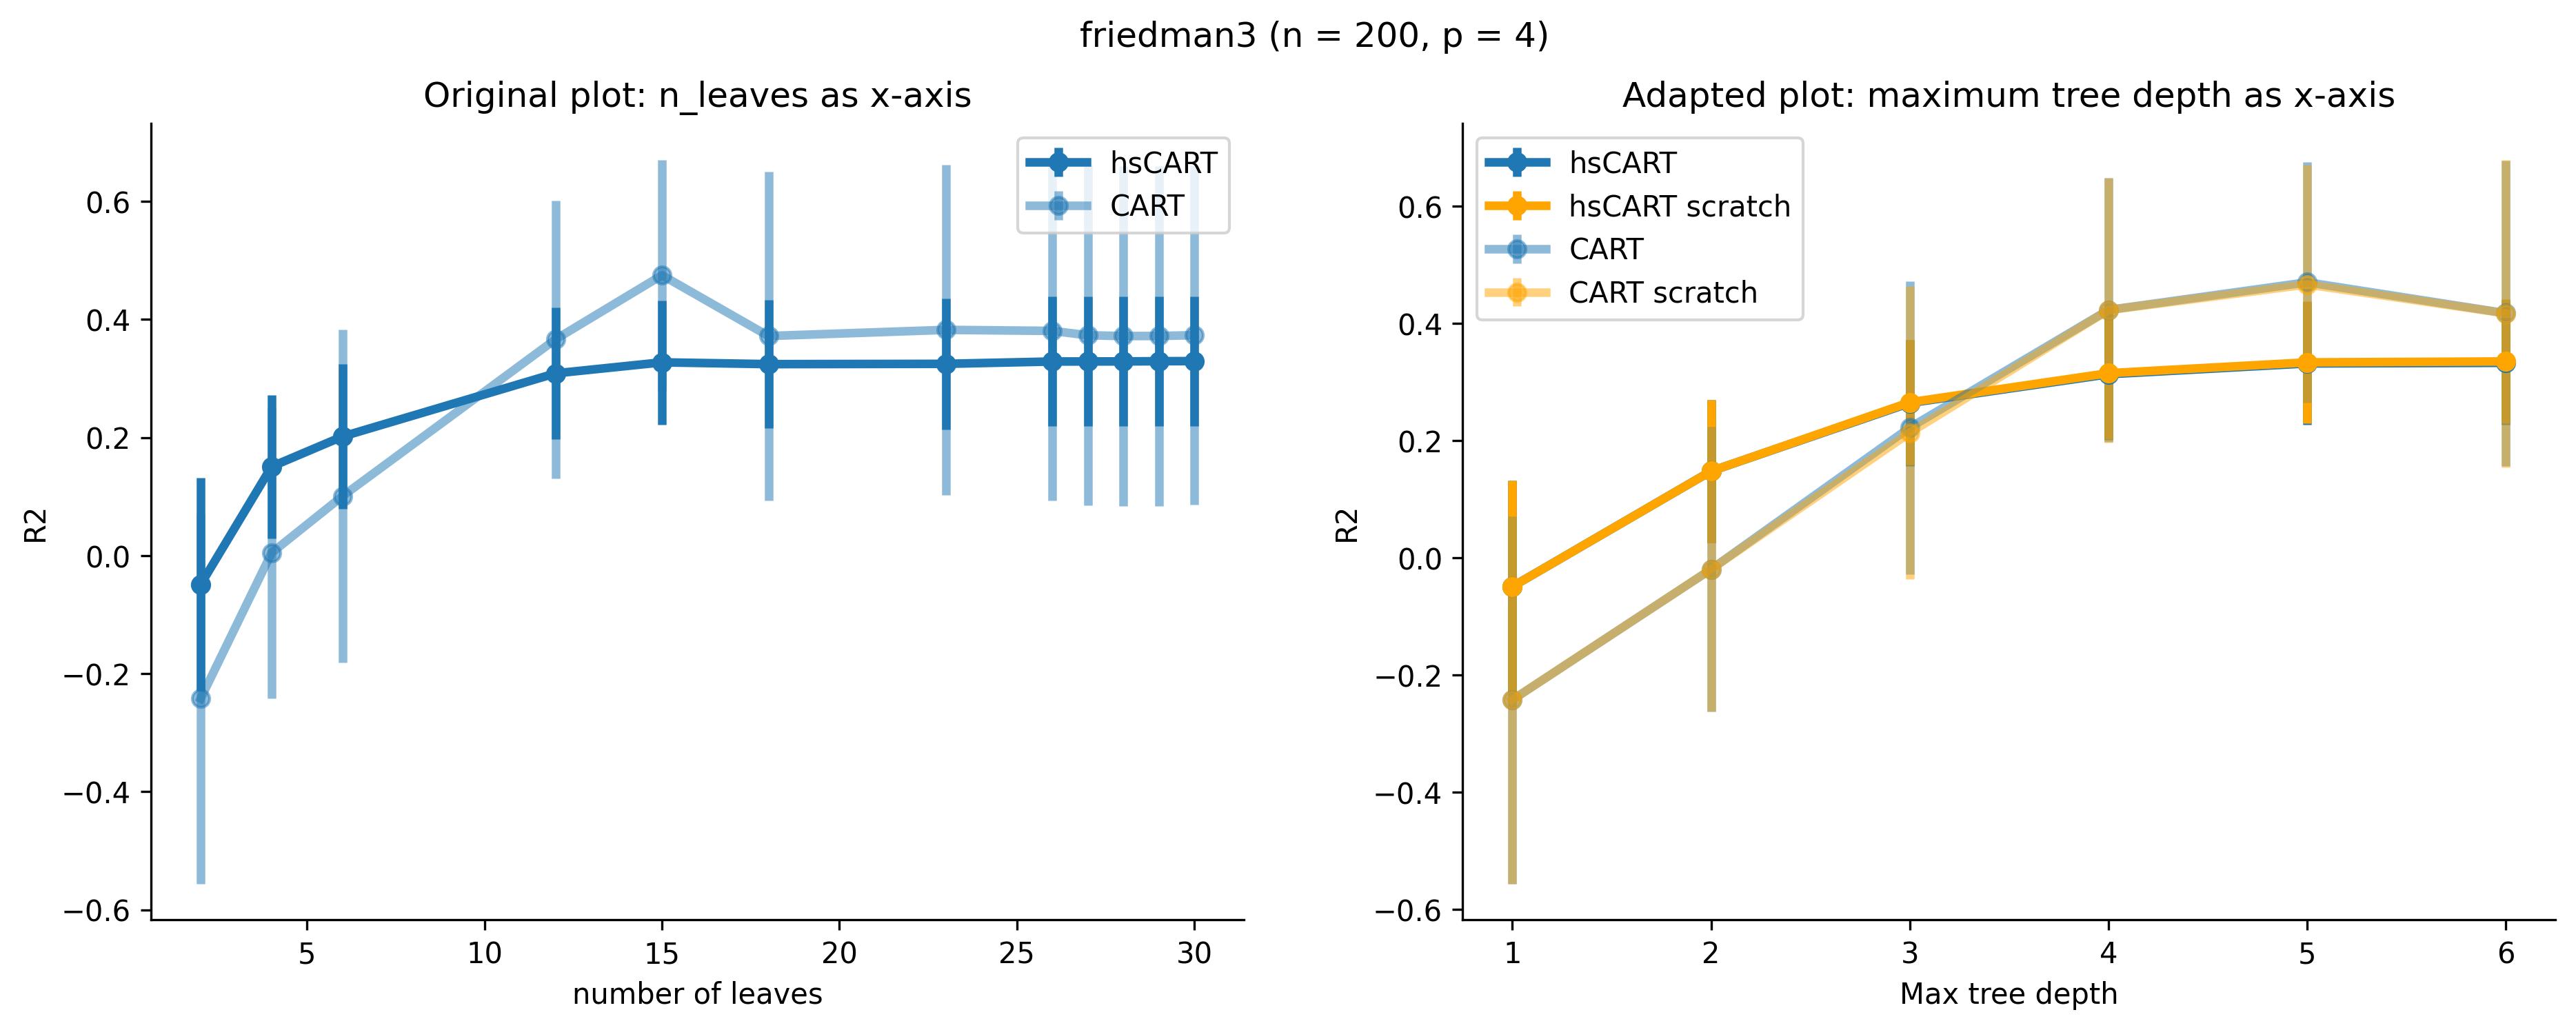

In [120]:
cv_res_frie3, cv_resfrie3 = create_performance_plot(X, y, scoring_func=r2_score, model_type="regression",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- Both plots appear to be similar to the original paper, but the r2 scores fall belwo the ones from the paper (max R2 of ~0.8)

#### Diabetes-regr dataset

In [122]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_REGRESSION[4]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

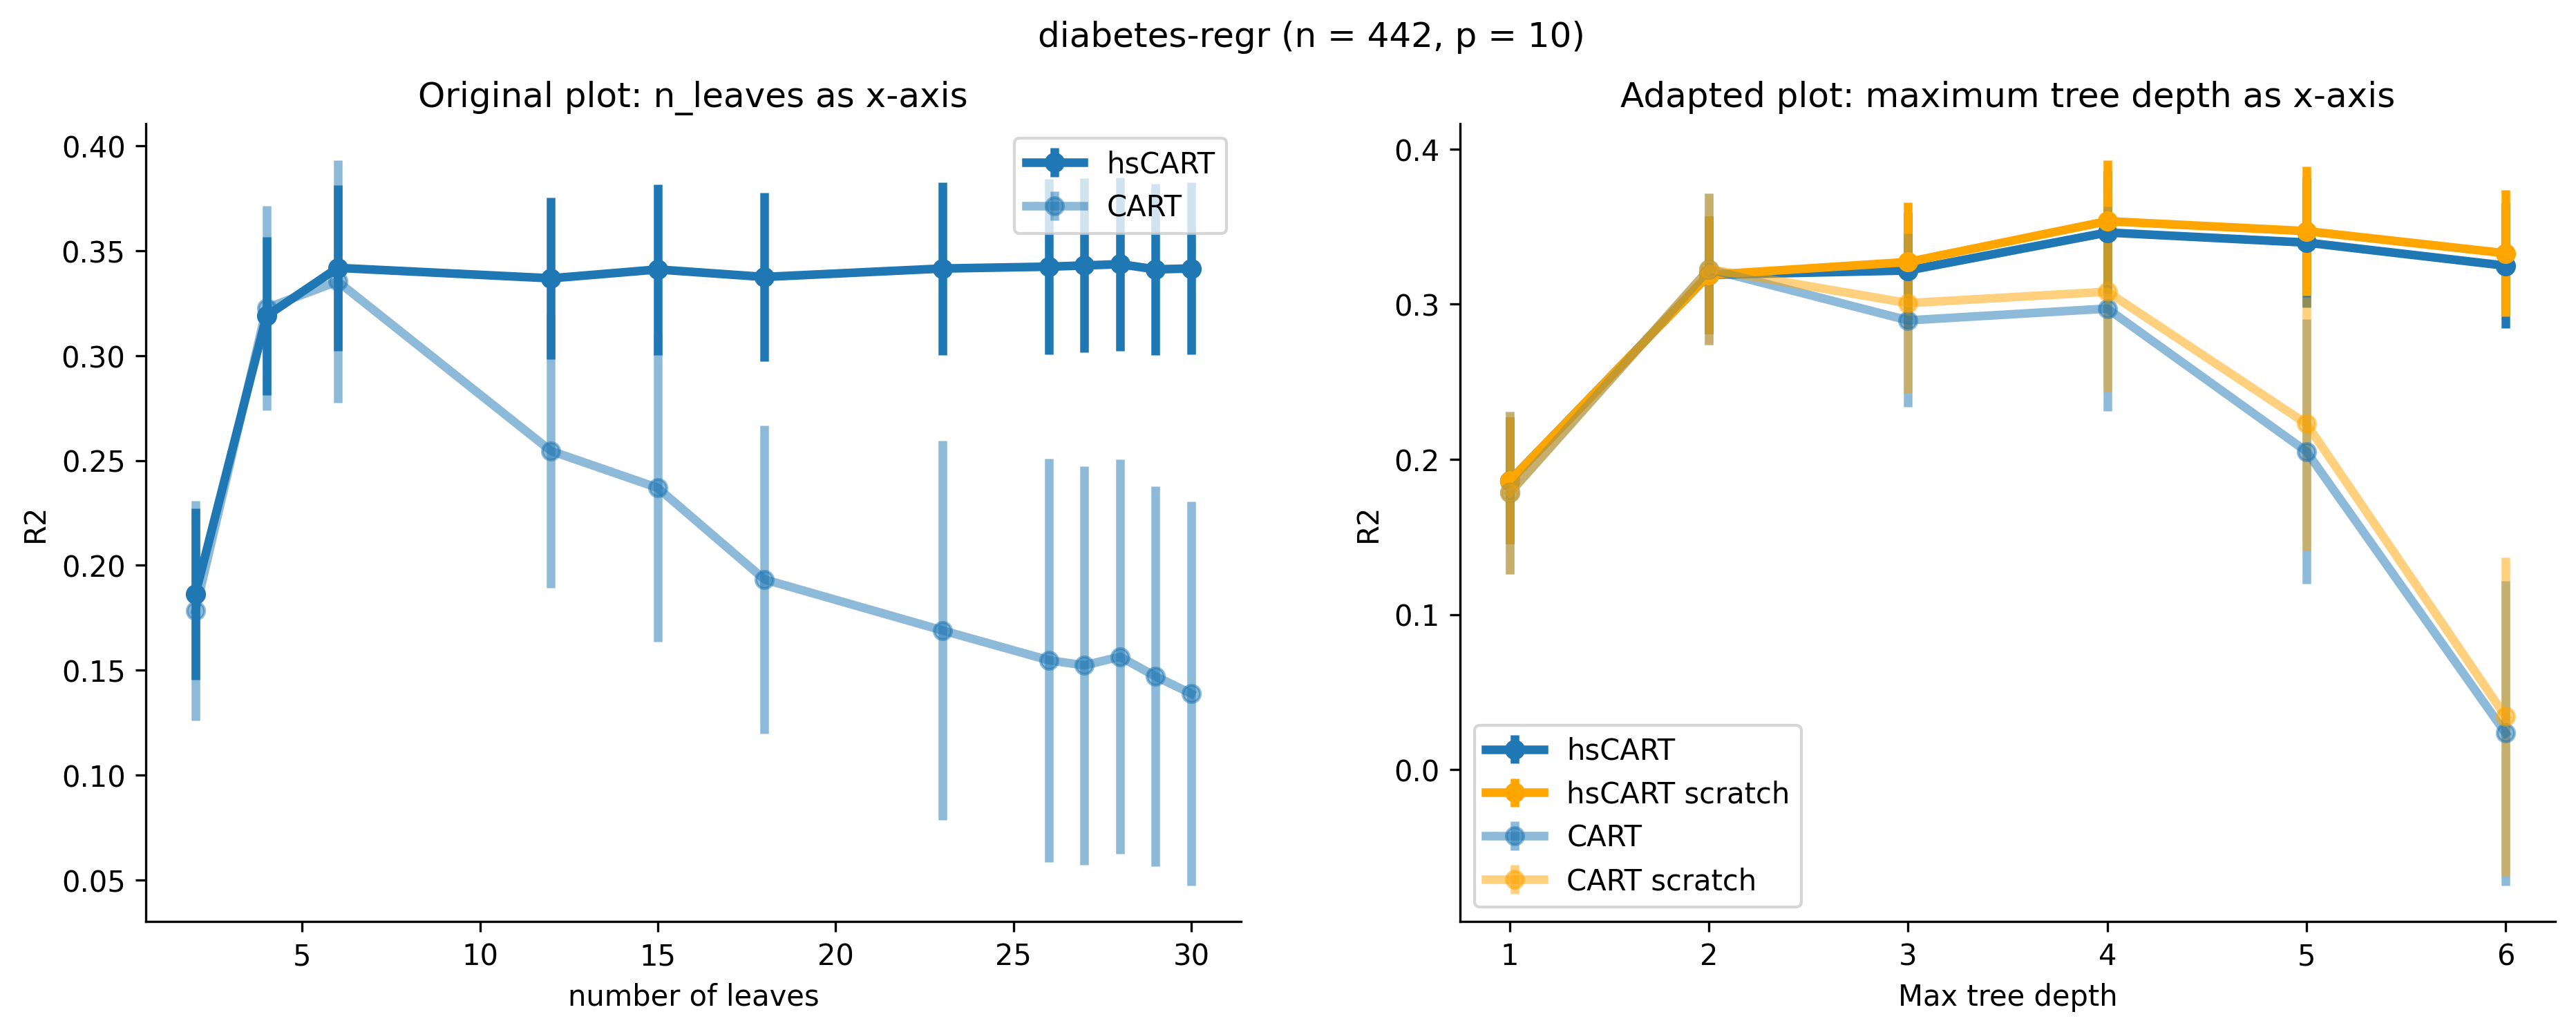

In [123]:
cv_res_diareg, cv_res_diareg = create_performance_plot(X, y, scoring_func=r2_score, model_type="regression",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- Both plots appear to be similar to the ooriginal paper

#### Red-wine & geographical music datasets (missing)
The `red-wine` and `geographical music` datasets were both removed from the authors. 

#### Abalone dataset

In [124]:
#Load dataset
dset_name, dset_file, data_source = DATASETS_REGRESSION[3]
X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

In [ ]:
cv_res_aba, cv_res_aba = create_performance_plot(X, y, scoring_func=r2_score, model_type="regression",
                                                      reg_param=100, shuffle=True, random_state=42, 
                                                      dset_name=dset_name, show_adapted_plot=True)

- Both plots appear to be similar to the original paper

#### Satellite-image dataset
This dataset is rather big and might take to long to compute without parallelization

In [ ]:
# #Load dataset
# dset_name, dset_file, data_source = DATASETS_REGRESSION[6]
# X, y, feat_names = get_clean_dataset(dset_file, data_source, DATASET_PATH)

In [ ]:
# cv_res_sat, cv_res_sat = create_performance_plot(X, y, scoring_func=r2_score, model_type="regression",
#                                                       reg_param=100, shuffle=True, random_state=42, 
#                                                       dset_name=dset_name, show_adapted_plot=True)